<a href="https://colab.research.google.com/github/Guilli12pm/ML_proj/blob/master/%40Notebook/project_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning project: Facial Recognition 

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
tf.enable_eager_execution()
tf.__version__

from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

##Download the images

In [ ]:
#https://github.com/Guilli12pm/ML_proj/raw/master/next_ite.tar.gz
import pathlib

data_root_orig = tf.keras.utils.get_file('next_ite',
                                         'https://github.com/Guilli12pm/ML_proj/raw/master/next_ite.tar.gz',
                                         untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

14106624/14099026 [==============================] - 0s 0us/step
/root/.keras/datasets/next_ite


##Inspect the dataset

In [ ]:
for item in data_root.iterdir():
  print(item)

/root/.keras/datasets/next_ite/.DS_Store
/root/.keras/datasets/next_ite/Miha_S
/root/.keras/datasets/next_ite/Guillaume_Paya
/root/.keras/datasets/next_ite/Guillaume_Loranchet
/root/.keras/datasets/next_ite/Nicholas_S


We create a list of all pictures and shuffle

In [ ]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)

In [ ]:
all_image_paths[:5]

['/root/.keras/datasets/next_ite/Guillaume_Loranchet/Guillaume_Loranchet_87.png',
 '/root/.keras/datasets/next_ite/Nicholas_S/Nicholas_6.png',
 '/root/.keras/datasets/next_ite/Guillaume_Loranchet/Guillaume_Loranchet_63.png',
 '/root/.keras/datasets/next_ite/Miha_S/Miha_S_86.png',
 '/root/.keras/datasets/next_ite/Miha_S/Miha_S_93.png']

###Show images

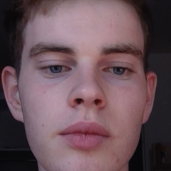

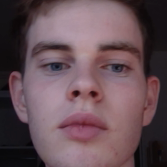

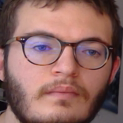

In [ ]:
import IPython.display as display

for n in range(3):
  image_path = random.choice(all_image_paths)
  #print('image path: ',image_path)
  display.display(display.Image(image_path))

###Label images

In [ ]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['Guillaume_Loranchet', 'Guillaume_Paya', 'Miha_S', 'Nicholas_S']

In [ ]:
for name in label_names:
  stri = '/root/.keras/datasets/next_ite/' + name + '/.DS_Store'
  all_image_paths.remove(stri)

In [ ]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'Guillaume_Loranchet': 0, 'Guillaume_Paya': 1, 'Miha_S': 2, 'Nicholas_S': 3}

In [ ]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [0, 3, 0, 2, 2, 1, 3, 2, 1, 2]


###Load images with Tensor Flow

In [ ]:
img_path = all_image_paths[0]
img_path


'/root/.keras/datasets/next_ite/Guillaume_Loranchet/Guillaume_Loranchet_87.png'

In [ ]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image

In [ ]:
def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

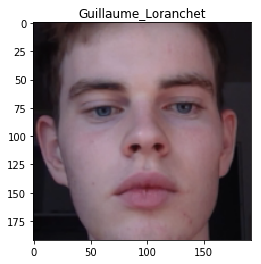

In [ ]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
#plt.xlabel(caption_image(img_path).encode('utf-8'))
plt.title(label_names[label].title())
print()

In [ ]:
n = len(all_image_paths)

x_train_aux = [load_and_preprocess_image(all_image_paths[i]) for i in range(len(all_image_paths))]
x_train_aux_2 = np.array([np.array(x_train_aux[i]) for i in range(n)])
x_train = x_train_aux_2[:int(0.75*n)]
x_test = x_train_aux_2[int(0.75*n):]
print(x_train.shape)
print(x_test.shape)

y_train_aux = np.array([[0]*i + [1] + [0]*(len(label_names)-1-i) for i in all_image_labels])
y_train = y_train_aux[:int(0.75*n)]
y_test = y_train_aux[int(0.75*n):]
print(y_train.shape)
print(y_test.shape)

labels = label_names
print(labels)

print(y_train[0])

(297, 192, 192, 3)
(99, 192, 192, 3)
(297, 4)
(99, 4)
['Guillaume_Loranchet', 'Guillaume_Paya', 'Miha_S', 'Nicholas_S']
[1 0 0 0]


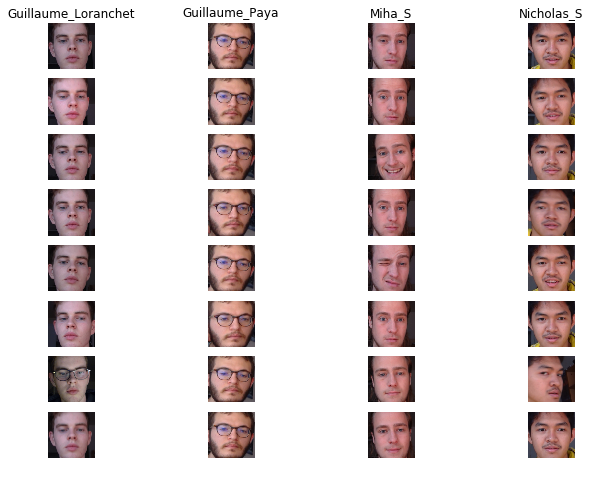

In [ ]:
def show_first_n_images_in_categories(n, images, categories, labels, file_name=None):
    """Plots the first n images in each category from the image data."""
    f, axes = plt.subplots(n, len(categories[0]), figsize=(11,8))
    
    for i in range(len(categories[0])):
        count = 0
        j = 0
        while count < n and j < 50000:
            if categories[j][i] == 1:
                axes[count,i].imshow(images[j,:,:,:])
                axes[count,i].axis('off')
                if count == 0:
                    axes[count,i].set_title(labels[i])
                count += 1
            j += 1

    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

show_first_n_images_in_categories(8, x_train, y_train, labels)

## Computing the mean square error

In [ ]:
print(x_train[0].shape)
print(y_train[0])

def mean_square_error(ima_1,ima_2):
  err = []
  n = len(ima_1)   #192
  for i in range(n):
    for j in range(n):
      for l in range(len(ima_1[0][0])):
        err.append((ima_1[i][j][l]- ima_2[i][j][l])**2)
  return 1/len(err) * sum(err)

def test(ima_test,label):
  print(label)
  x1, x2, x3, x4 = [],[],[],[]
  for i in range(0,len(x_train)):
    if y_train[i][0]:
      x1.append(mean_square_error(ima_test,x_train[i]))
    elif y_train[i][1]:
      x2.append(mean_square_error(ima_test,x_train[i]))
    elif y_train[i][2]:
      x3.append(mean_square_error(ima_test,x_train[i]))
    elif y_train[i][3]:
      x4.append(mean_square_error(ima_test,x_train[i]))

  liste = [np.mean(x1),np.mean(x2),np.mean(x3),np.mean(x4)]
  return liste

def test_over_all_test_image():
  for j in range(20):
    liste = test(x_test[j],y_test[j])
    mi = min(liste)
    liste2 = [0 if liste[i] != mi else 1 for i in range(len(liste))]
    print(liste2,'\n')
    
#test_over_all_test_image()

(192, 192, 3)
[0 0 1 0]


##Naive Model

In [ ]:
def train_model(model, x, y, x_test, y_test, batch_size=128, epochs=10, file_name=None):
    """
    Trains the model on the given data.
    """
    
    stop_early = keras.callbacks.EarlyStopping(
        monitor='val_acc', min_delta=0, patience=2, mode='auto')

    ret = model.fit(x, y, batch_size=batch_size, epochs=epochs, 
        validation_data=(x_test, y_test), shuffle=True)#, callbacks=[stop_early])
    
    if file_name:
        model.save(file_name)
    
    return ret

In [ ]:
def dense_model(input_shape, num_classes):
    model = keras.models.Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(2048, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='linear'))

    sgd = SGD(lr=0.1, decay=1.0e-6)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model


#model = dense_model(x_train.shape[1:], len(labels))
#model.summary()
#ret = train_model(model, x_train, y_train, x_test, y_test)


##Convutional Net

In [ ]:
def cnn_model(input_shape, num_classes):
    model = keras.models.Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    sgd = SGD(lr=0.1, decay=1.0e-6)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# Create and train model
model = cnn_model(x_train.shape[1:], len(labels))
model.summary()

# Train the model
ret = train_model(model, x_train, y_train, x_test, y_test)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 192, 192, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 190, 190, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 190, 190, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 32)        0         
_________________________________________________________________
batch_normalization_v

##Testing

[1.05830995e-11 1.00000000e+00 6.34123642e-09 5.22656363e-10]
[2.0950540e-13 1.0000000e+00 1.1958681e-09 4.5235543e-12]
[2.2846403e-10 9.9999976e-01 2.5982047e-07 1.8387185e-09]
[1.0231850e-12 1.0000000e+00 6.2785910e-10 2.2806559e-11]


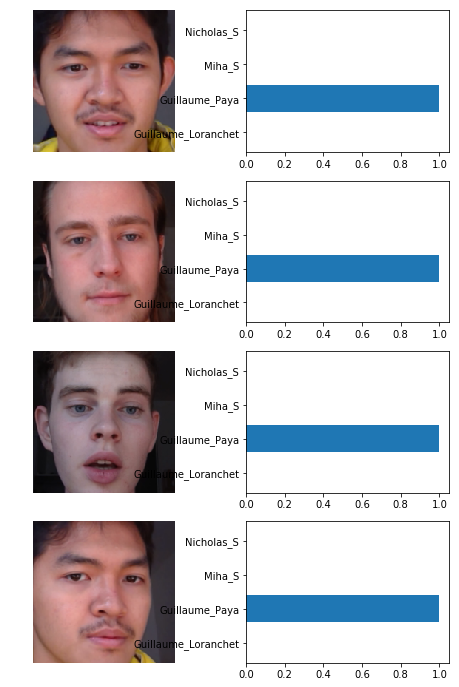

In [ ]:
def predict(model, x, labels, file_name=None):
    y = model.predict(x)

    f, ax = plt.subplots(x.shape[0], 2, figsize=(8,12))
    y_pos = np.arange(len(labels))

    for i in range(x.shape[0]):
        ax[i,0].imshow(x[i,:,:,:])
        ax[i,0].axis('off')
        ax[i,1].barh(y_pos, y[i,:],align='center')
        ax[i,1].set_yticks(y_pos)
        ax[i,1].set_yticklabels(labels)
        print(y[i,:])
    
    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()
        
import random
i = random.randint(1,75)
predict(model, x_test[i:i+4,:,:,:], labels)


##Build a tf.dataset

In [ ]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [ ]:
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)

shape:  TensorShape([])
type:  <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>


In [ ]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

Instructions for updating:
Colocations handled automatically by placer.


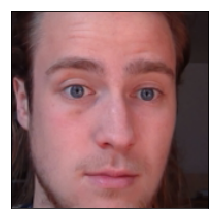

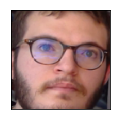

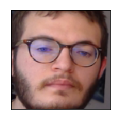

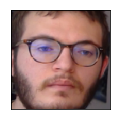

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  #plt.xlabel(caption_image(all_image_paths[n]))
  plt.show()

In [ ]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [ ]:
for label in label_ds.take(10):
  print(label_names[label.numpy()])

Miha_S
Guillaume_Paya
Guillaume_Paya
Guillaume_Paya
Guillaume_Paya
Guillaume_Paya
Miha_S
Nicholas_S
Miha_S
Guillaume_Paya


In [ ]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [ ]:
print(image_label_ds)

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [ ]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

In [ ]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [ ]:
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [ ]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

9412608/9406464 [==============================] - 1s 0us/step


In [ ]:
def change_range(image,label):
  return 2*image-1, label

keras_ds = ds.map(change_range)

In [ ]:
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
image_batch, label_batch = next(iter(keras_ds))

In [ ]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 6, 6, 1280)


In [ ]:
model = tf.keras.Sequential([
  mobile_net,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(label_names))])

In [ ]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: -1.5796653
max logit: 1.8470368

Shape: (32, 4)


In [ ]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [ ]:
len(model.trainable_variables)

2

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
steps_per_epoch=tf.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

13.0

In [ ]:
model.fit(ds, epochs=1, steps_per_epoch=3)

3/3 [==============================] - 12s 4s/step - loss: 5.5652 - acc: 0.1875


In [ ]:
import time

def timeit(ds, batches=2*steps_per_epoch+1):
  overall_start = time.time()
  # Fetch a single batch to prime the pipeline (fill the shuffle buffer),
  # before starting the timer
  it = iter(ds.take(batches+1))
  next(it)

  start = time.time()
  for i,(images,labels) in enumerate(it):
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(batches, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*batches/duration))
  print("Total time: {}s".format(end-overall_start))

In [ ]:
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [ ]:
timeit(ds)

...
27.0 batches: 1.8377976417541504 s
470.12793 Images/s
Total time: 2.5691800117492676s


In [ ]:
ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [ ]:
timeit(ds)

...
27.0 batches: 1.616187572479248 s
534.59141 Images/s
Total time: 2.3432955741882324s


In [ ]:
ds = image_label_ds.cache()
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [ ]:
timeit(ds)

...
27.0 batches: 0.18660402297973633 s
4630.12526 Images/s
Total time: 0.8874011039733887s


In [ ]:
image_ds = tf.data.Dataset.from_tensor_slices(all_image_paths).map(tf.read_file)
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(image_ds)

In [ ]:
image_ds = tf.data.TFRecordDataset('images.tfrec').map(preprocess_image)

In [ ]:
ds = tf.data.Dataset.zip((image_ds, label_ds))
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds=ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int64)>

In [ ]:
timeit(ds)

...
27.0 batches: 1.4800910949707031 s
583.74785 Images/s
Total time: 2.1226065158843994s


In [ ]:
paths_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = paths_ds.map(load_and_preprocess_image)
image_ds

<DatasetV1Adapter shapes: (192, 192, 3), types: tf.float32>

In [ ]:
ds = image_ds.map(tf.serialize_tensor)
ds

<DatasetV1Adapter shapes: (), types: tf.string>

In [ ]:
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(ds)

In [ ]:
ds = tf.data.TFRecordDataset('images.tfrec')

def parse(x):
  result = tf.parse_tensor(x, out_type=tf.float32)
  result = tf.reshape(result, [192, 192, 3])
  return result

ds = ds.map(parse, num_parallel_calls=AUTOTUNE)
ds

<DatasetV1Adapter shapes: (192, 192, 3), types: tf.float32>

In [ ]:
ds = tf.data.Dataset.zip((ds, label_ds))
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds=ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int64)>